02:01:05 - cmdstanpy - INFO - Chain [1] start processing
02:01:05 - cmdstanpy - INFO - Chain [1] done processing


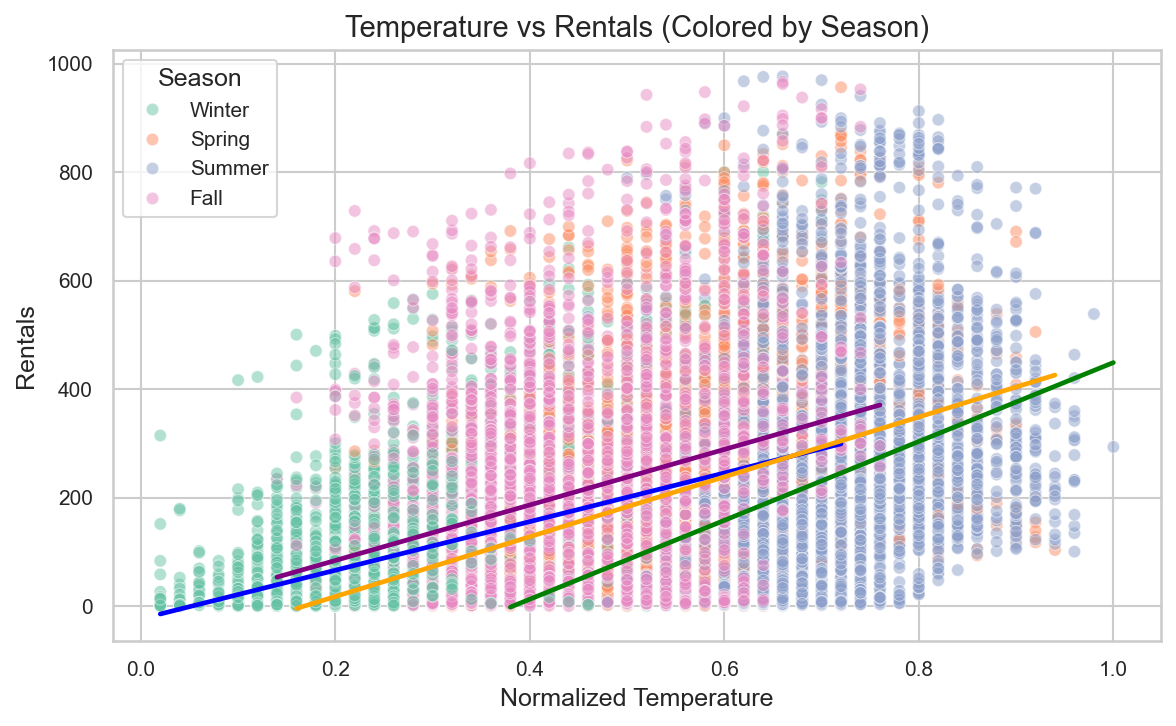

/var/folders/x8/3h_bm8d17flf32mfss6sz9nm0000gn/T/ipykernel_62959/1029381268.py:226: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_season, x='season_label', y='cnt', palette='Set2')


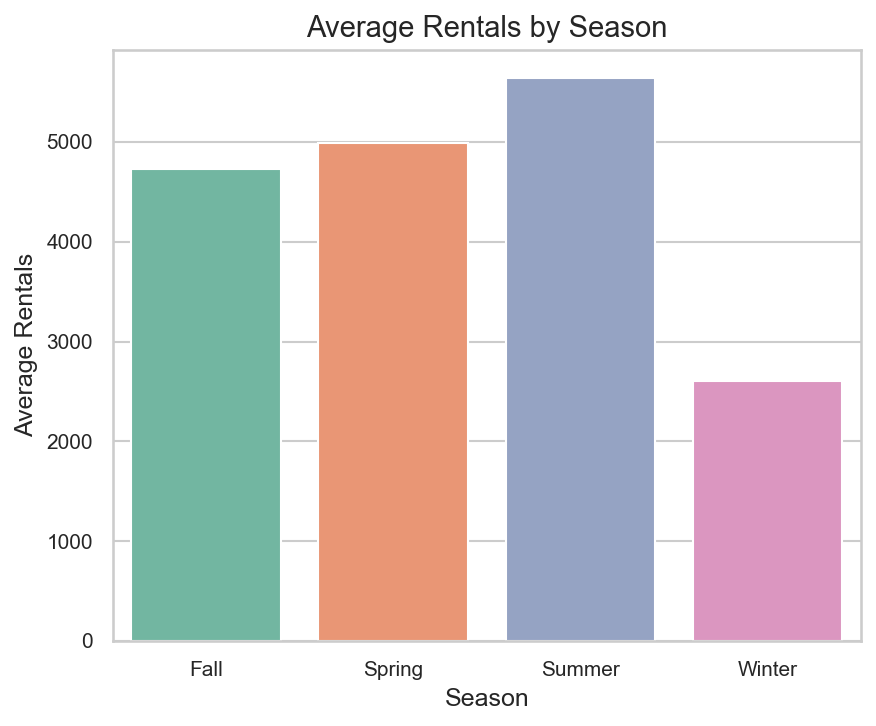

<Figure size 1200x750 with 0 Axes>

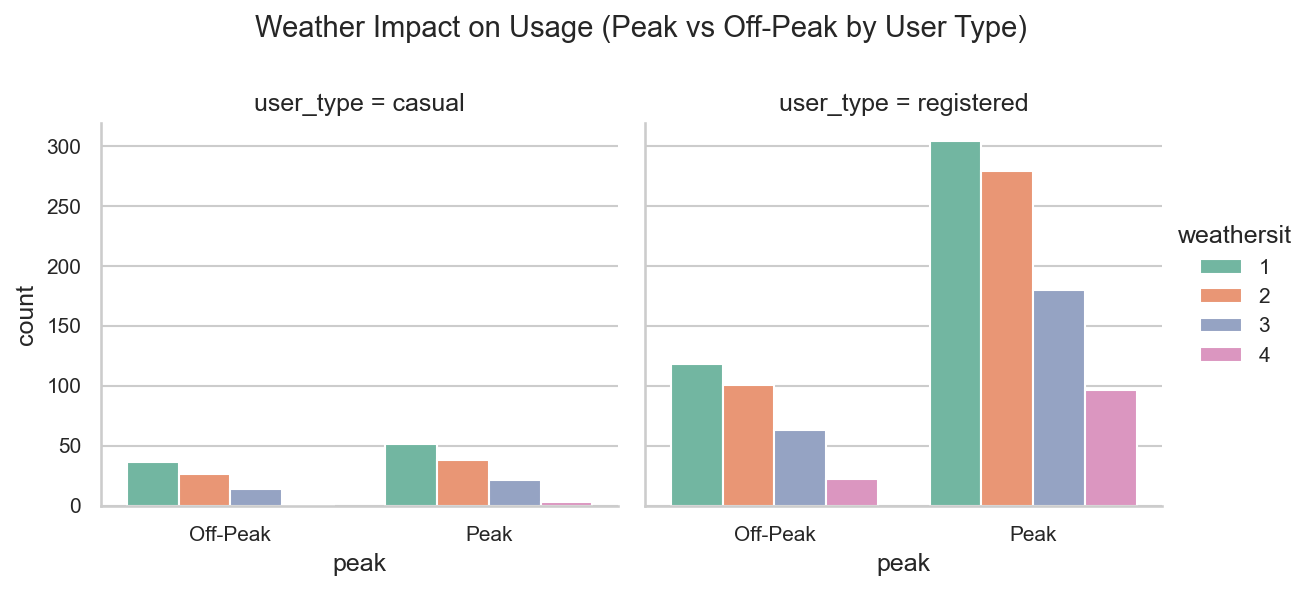

/var/folders/x8/3h_bm8d17flf32mfss6sz9nm0000gn/T/ipykernel_62959/1029381268.py:270: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=comp, x='weathersit', y='pct_change', palette='coolwarm')


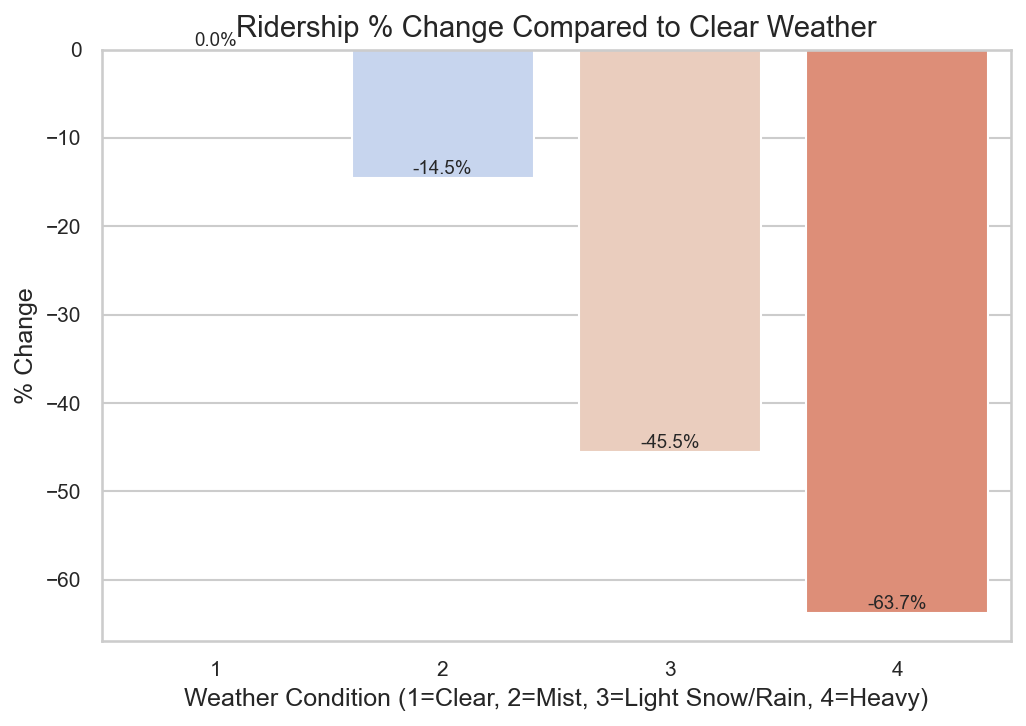

✅ All static PNG plots saved in: plots_static


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from prophet import Prophet
import os

# ---------------------------
# CONFIGURATION
# ---------------------------
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10
})
output_dir = "plots_static"
os.makedirs(output_dir, exist_ok=True)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Accessible blue/orange/green

# ---------------------------
# LOAD DATA
# ---------------------------
hour_df = pd.read_csv("hour.csv")
day_df = pd.read_csv("day.csv")
hour_df['dteday'] = pd.to_datetime(hour_df['dteday'])
day_df['dteday'] = pd.to_datetime(day_df['dteday'])

# Feature engineering
season_map = {1:'Winter',2:'Spring',3:'Summer',4:'Fall'}
hour_df['season_label'] = hour_df['season'].map(season_map)
day_df['season_label'] = day_df['season'].map(season_map)
hour_df['day_type'] = hour_df['weekday'].apply(lambda x: 'Weekend/Holiday' if x in [0,6] else 'Working Day')
day_df['day_type'] = day_df['workingday'].apply(lambda x: 'Working Day' if x==1 else 'Weekend/Holiday')
hour_df['hour_label'] = hour_df['hr'].apply(lambda x: f"{x:02d}:00")

# ---------------------------
# 1. Average Hourly Demand
# ---------------------------
hourly_means = hour_df.groupby('hr')[['casual','registered']].mean()
fig, ax = plt.subplots(figsize=(8,5))
hourly_means.plot(kind='bar', stacked=False, ax=ax, color=[colors[0], colors[1]])
ax.set_title("Average Hourly Demand (Casual vs Registered)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Rentals")
ax.legend(["Casual","Registered"])
plt.tight_layout()
plt.savefig(f"{output_dir}/avg_hourly_demand.png")
plt.close()

# ---------------------------
# 2. Weekday vs Weekend
# ---------------------------
hourly_daytype = hour_df.groupby(['hr','day_type'])['cnt'].mean().reset_index()
fig, ax = plt.subplots(figsize=(8,5))
for i, d in enumerate(hourly_daytype['day_type'].unique()):
    subset = hourly_daytype[hourly_daytype['day_type']==d]
    ax.plot(subset['hr'], subset['cnt'], marker='o', label=d, color=colors[i])
ax.set_title("Average Hourly Demand: Weekday vs Weekend")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Rentals")
ax.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/avg_hourly_weekday_weekend.png")
plt.close()

# ---------------------------
# 3. Temperature vs Rentals (Density)
# ---------------------------
fig, ax = plt.subplots(figsize=(6,5))
sns.kdeplot(data=hour_df, x='temp', y='cnt', fill=True, cmap='Blues', ax=ax, thresh=0.05)
ax.set_title("Density: Temperature vs Total Rentals")
ax.set_xlabel("Normalized Temperature")
ax.set_ylabel("Total Rentals")
plt.tight_layout()
plt.savefig(f"{output_dir}/density_temp_vs_rentals.png")
plt.close()

# ---------------------------
# 4. Average Usage by Season and Day Type
# ---------------------------
season_day = day_df.groupby(['season_label','day_type'])['cnt'].mean().reset_index()
fig, ax = plt.subplots(figsize=(6,5))
sns.barplot(data=season_day, x='season_label', y='cnt', hue='day_type', palette=colors[:2], ax=ax)
ax.set_title("Average Usage by Season and Day Type")
ax.set_xlabel("Season")
ax.set_ylabel("Average Rentals")
ax.legend(title="Day Type")
plt.tight_layout()
plt.savefig(f"{output_dir}/avg_usage_season_daytype.png")
plt.close()

# ---------------------------
# 5. Cumulative Monthly Rides
# ---------------------------
month_df = day_df.copy()
month_df['yearmonth'] = month_df['dteday'].dt.to_period('M')
cumulative = month_df.groupby('yearmonth')[['casual','registered']].sum().cumsum().reset_index()
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cumulative['yearmonth'].astype(str), cumulative['casual'], marker='o', label='Casual', color=colors[0])
ax.plot(cumulative['yearmonth'].astype(str), cumulative['registered'], marker='o', label='Registered', color=colors[1])
ax.set_title("Cumulative Monthly Rides")
ax.set_xlabel("Month")
ax.set_ylabel("Cumulative Rides")
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{output_dir}/cumulative_monthly.png")
plt.close()

# ---------------------------
# 6. Hourly Demand Clustering
# ---------------------------
hourly_vals = hour_df.groupby('hr')['cnt'].mean().values.reshape(-1,1)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(hourly_vals)
clustered = pd.DataFrame({'Hour':range(24),
                          'Avg Rentals':hour_df.groupby('hr')['cnt'].mean().values,
                          'Cluster':labels})
# manually label clusters after inspection
cluster_map = {
    0:'High Demand (Peak)',
    1:'Moderate Demand',
    2:'Low Demand (Off-Peak)'
}
clustered['Cluster Label'] = clustered['Cluster'].map(cluster_map)
fig, ax = plt.subplots(figsize=(8,5))
for label, data in clustered.groupby('Cluster Label'):
    ax.plot(data['Hour'], data['Avg Rentals'], marker='o', label=label)
ax.set_title("Hourly Demand Profiles (Clusters)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Rentals")
ax.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/hourly_clusters.png")
plt.close()

# ---------------------------
# 7. Rolling Average
# ---------------------------
day_df['cnt_rolling7'] = day_df['cnt'].rolling(window=7).mean()
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(day_df['dteday'], day_df['cnt'], alpha=0.4, label='Daily Rentals', color=colors[0])
ax.plot(day_df['dteday'], day_df['cnt_rolling7'], label='7-Day Rolling Avg', color=colors[1])
ax.set_title("Daily Rentals with 7-Day Rolling Average")
ax.set_xlabel("Date")
ax.set_ylabel("Total Rentals")
ax.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/daily_rolling_avg.png")
plt.close()

# ---------------------------
# 8. Anomaly Detection
# ---------------------------
daily_series = day_df.set_index('dteday')['cnt']
smoothed = daily_series.rolling(window=7, center=True, min_periods=1).mean()
residuals = daily_series - smoothed
std = residuals.std()
threshold = 2.5
anomalies = residuals[np.abs(residuals) > threshold * std]
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(daily_series.index, smoothed, label='Smoothed Total Rides', color=colors[0])
ax.scatter(anomalies.index, daily_series[anomalies.index], color='red', label='Anomalies', s=30, marker='x')
ax.set_title("Daily Total Rides with Anomalies Highlighted (Smoothed)")
ax.set_xlabel("Date")
ax.set_ylabel("Total Rides")
ax.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/anomaly_plot.png")
plt.close()

# ---------------------------
# 9. Forecasting with Prophet
# ---------------------------
prophet_df = day_df[['dteday','casual','registered']].copy()
prophet_df['y'] = prophet_df['casual'] + prophet_df['registered']
prophet_df = prophet_df.rename(columns={'dteday':'ds'})
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='additive', interval_width=0.95)
m.fit(prophet_df[['ds','y']])
future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(prophet_df['ds'], prophet_df['y'], label='Historical', color=colors[0])
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color=colors[1])
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
ax.set_title("60-Day Forecast of Total Rides")
ax.set_xlabel("Date")
ax.set_ylabel("Total Rides")
ax.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/forecast_plot.png")
plt.close()

# ==============================
# 10: Temperature vs Rentals by Season
# ==============================
plt.figure(figsize=(8,5))
sns.scatterplot(data=hour_df, x='temp', y='cnt', hue='season_label', alpha=0.5, palette='Set2')
sns.regplot(data=hour_df[hour_df['season_label']=='Winter'], x='temp', y='cnt', scatter=False, color='blue', ci=None)
sns.regplot(data=hour_df[hour_df['season_label']=='Spring'], x='temp', y='cnt', scatter=False, color='orange', ci=None)
sns.regplot(data=hour_df[hour_df['season_label']=='Summer'], x='temp', y='cnt', scatter=False, color='green', ci=None)
sns.regplot(data=hour_df[hour_df['season_label']=='Fall'], x='temp', y='cnt', scatter=False, color='purple', ci=None)
plt.title("Temperature vs Rentals (Colored by Season)")
plt.xlabel("Normalized Temperature")
plt.ylabel("Rentals")
plt.legend(title='Season')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "temp_vs_rentals_season.png"))
plt.show()


# ==============================
# 11: Average Rentals by Season
# ==============================
avg_season = day_df.groupby('season_label')['cnt'].mean().reset_index()

plt.figure(figsize=(6,5))
sns.barplot(data=avg_season, x='season_label', y='cnt', palette='Set2')
plt.title("Average Rentals by Season")
plt.xlabel("Season")
plt.ylabel("Average Rentals")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "avg_rentals_by_season.png"))
plt.show()



# ==============================
# 12: Weather Impact Peak vs Off-Peak by User Type
# ==============================
# define peak hours
peak_hours = list(range(7,10)) + list(range(16,19))
hour_df['peak'] = hour_df['hr'].apply(lambda h: 'Peak' if h in peak_hours else 'Off-Peak')

melted = hour_df.melt(
    id_vars=['weathersit','peak'],
    value_vars=['casual','registered'],
    var_name='user_type',
    value_name='count'
)
agg = melted.groupby(['user_type','peak','weathersit'])['count'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.catplot(
    data=agg, x='peak', y='count', hue='weathersit',
    col='user_type', kind='bar', height=4, aspect=1,
    palette='Set2'
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Weather Impact on Usage (Peak vs Off-Peak by User Type)", fontsize=14)
plt.savefig(os.path.join(output_dir, "weather_impact_peak_offpeak.png"))
plt.show()

# ==============================
# 13: Ridership % Change Compared to Clear Weather
# ==============================
baseline = hour_df[hour_df['weathersit']==1]['cnt'].mean()
comp = hour_df.groupby(['weathersit'])['cnt'].mean().reset_index()
comp['pct_change'] = (comp['cnt']-baseline)/baseline*100

plt.figure(figsize=(7,5))
bars = sns.barplot(data=comp, x='weathersit', y='pct_change', palette='coolwarm')
plt.title("Ridership % Change Compared to Clear Weather")
plt.xlabel("Weather Condition (1=Clear, 2=Mist, 3=Light Snow/Rain, 4=Heavy)")
plt.ylabel("% Change")
for p in bars.patches:
    bars.annotate(f"{p.get_height():.1f}%", 
                  (p.get_x()+p.get_width()/2., p.get_height()), 
                  ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "ridership_pct_change.png"))
plt.show()



print(f"All static PNG plots saved in: {output_dir}")
